## This notebook check the M1M3 state transitions and force commands

## It also checks the LUT against the input polynomials, before and after a slew


In [2]:
from lsst.ts import salobj
import asyncio
import os

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd

from lsst.ts.idl.enums import MTM1M3
from M1M3tools import *
from ptgTools import ptgSlew

plt.jet();

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/jose/backends/cryptography_backend.py:23: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes, int_to_bytes


<Figure size 432x288 with 0 Axes>

In [2]:
import os
print(os.environ["OSPL_URI"])
if os.environ.get("LSST_DDS_ALIGNER", "false") != "false":
    print("LSST_DDS_ALIGNER is mis-configured")

file:///home/bxin/ts_ddsconfig/config/ospl-sp.xml


In [3]:
start_time = datetime.now()
script = salobj.Controller("Script", index=1)
await asyncio.sleep(10) #wait 10 second may help with DDS problems; closing all other kernels may help too
m1m3 = salobj.Remote(script.domain, "MTM1M3", exclude=['logMessage'])
ptg = salobj.Remote(script.domain, "MTPtg")
mount = salobj.Remote(script.domain, "MTMount")
rot = salobj.Remote(script.domain, "MTRotator")
print(f'time to start is {datetime.now() - start_time} [s]')

time to start is 0:00:42.232291 [s]


In [4]:
await asyncio.gather(ptg.start_task,
                     mount.start_task,
                     script.start_task, #                     
                     rot.start_task,
                     m1m3.start_task)

elevation DDS read queue is filling: 14 of 100 elements
cameraCableWrap DDS read queue is filling: 14 of 100 elements
azimuth DDS read queue is filling: 15 of 100 elements


[None, None, None, None, None]

timeAndDate DDS read queue is filling: 27 of 100 elements
mountStatus DDS read queue is filling: 30 of 100 elements
powerSupplyData DDS read queue is full (100 elements); data may be lost
guidingAndOffsets DDS read queue is filling: 30 of 100 elements
currentTargetStatus DDS read queue is filling: 31 of 100 elements
inclinometerData DDS read queue is full (100 elements); data may be lost
imsData DDS read queue is full (100 elements); data may be lost
hardpointMonitorData DDS read queue is full (100 elements); data may be lost
hardpointActuatorData DDS read queue is full (100 elements); data may be lost
gyroData DDS read queue is full (100 elements); data may be lost
forceActuatorData DDS read queue is full (100 elements); data may be lost
accelerometerData DDS read queue is full (100 elements); data may be lost
appliedStaticForces DDS read queue is filling: 10 of 100 elements
appliedForces DDS read queue is filling: 11 of 100 elements
appliedElevationForces DDS read queue is filling: 1

### test state transition. If m1m3 is already enabled, disable then enable it.

In [53]:
sstate = await m1m3.evt_summaryState.aget(timeout=5)
print('staring with: m1m3 state',salobj.State(sstate.summaryState), pd.to_datetime(sstate.private_sndStamp, unit='s'))
dstate = await m1m3.evt_detailedState.aget(timeout=200)
print('m1m3 state', MTM1M3.DetailedState(dstate.detailedState), pd.to_datetime(dstate.private_sndStamp, unit='s'))

staring with: m1m3 state State.ENABLED 2021-03-02 20:40:22.224690688
m1m3 state DetailedState.ACTIVE 2021-03-02 20:40:22.224828416


In [54]:
async def lower(m1m3):
    m1m3.evt_detailedState.flush()
    await m1m3.cmd_lowerM1M3.set_start(lowerM1M3=True, timeout = 30)
    while True:
        state = await m1m3.evt_detailedState.next(flush=False, timeout=300)
        print('m1m3 state', MTM1M3.DetailedState(state.detailedState), pd.to_datetime(state.private_sndStamp, unit='s'))
        if (MTM1M3.DetailedState(state.detailedState) == MTM1M3.DetailedState.PARKED
                or MTM1M3.DetailedState(state.detailedState) == MTM1M3.DetailedState.PARKEDENGINEERING):
            break

async def raise(m1m3):
    m1m3.evt_detailedState.flush()
    await m1m3.cmd_raiseM1M3.set_start(raiseM1M3=True, timeout = 30)
    while True:
        state = await m1m3.evt_detailedState.next(flush=False, timeout=300)
        print('m1m3 state', MTM1M3.DetailedState(state.detailedState), pd.to_datetime(state.private_sndStamp, unit='s'))
        if (MTM1M3.DetailedState(state.detailedState) == MTM1M3.DetailedState.ACTIVE
                or MTM1M3.DetailedState(state.detailedState) == MTM1M3.DetailedState.ACTIVEENGINEERING):
            break
        
if (MTM1M3.DetailedState(dstate.detailedState) == MTM1M3.DetailedState.ACTIVEENGINEERING
        or MTM1M3.DetailedState(dstate.detailedState) == MTM1M3.DetailedState.ACTIVE):
    await lower(m1m3)

m1m3 state DetailedState.LOWERINGENGINEERING 2021-03-02 20:46:30.949536768
m1m3 state DetailedState.PARKEDENGINEERING 2021-03-02 20:47:27.877379328


CancelledError: 

In [18]:
#As long as you get something for the payload its OK. we dont' care about h.heartbeat
await m1m3.evt_heartbeat.next(flush=True, timeout=5)

In [30]:
if sstate.summaryState == salobj.State.ENABLED:
    await salobj.set_summary_state(m1m3, salobj.State.DISABLED) #disable m1m3
if sstate.summaryState == salobj.State.FAULT:
    await m1m3.cmd_clearErrors.set_start()
if sstate.summaryState == salobj.State.STANDBY:
    await m1m3.cmd_start.set_start(settingsToApply="Default")
await salobj.set_summary_state(m1m3, salobj.State.ENABLED) #enable m1m3

[<State.DISABLED: 1>, <State.ENABLED: 2>]

In [ ]:
#for now, we have to enter engineering state for the force commands to work
await m1m3.cmd_enterEngineering.start()

In [35]:
#may need to wait a few seconds before event shows up in EFD
await asyncio.sleep(10.)
from lsst_efd_client import EfdClient

client = EfdClient('ncsa_teststand_efd')
csc_index = 1
end = Time(datetime.now())
start = end - timedelta(hours=1)
dfe = await client.select_time_series('lsst.sal.MTM1M3.logevent_summaryState', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
#to check messages in Kafka, go to https://lsst-kafka-0-nts-efd.ncsa.illinois.edu/
##we cannot get time series data from DDS. We have to query the EFD

In [37]:
dfe.tail(5)

,priority,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,summaryState
2021-03-02 20:38:10.781000+00:00,0,1,MTM1M3,1.614717e+09,188378,1.614717e+09,3974e3c4,23,1.614717e+09,2
2021-03-02 20:38:40.948000+00:00,0,1,MTM1M3,1.614718e+09,188378,1.614718e+09,3974e3c4,24,1.614718e+09,1
2021-03-02 20:38:40.960000+00:00,0,1,MTM1M3,1.614718e+09,188378,1.614718e+09,3974e3c4,25,1.614718e+09,2
2021-03-02 20:39:24.639000+00:00,0,1,MTM1M3,1.614718e+09,188378,1.614718e+09,3974e3c4,26,1.614718e+09,2
2021-03-02 20:40:22.224000+00:00,0,1,MTM1M3,1.614718e+09,188378,1.614718e+09,3974e3c4,27,1.614718e+09,2


### Raise M1M3

In [32]:
m1m3Angle = await m1m3.tel_inclinometerData.aget()
print("m1m3Angle", m1m3Angle.inclinometerAngle)

m1m3Angle 20.196998596191406


In [33]:
m1m3HP = await m1m3.tel_hardpointActuatorData.aget()
print("m1m3 z", m1m3HP.zPosition)

m1m3 z 2.6919990432361374e-06


In [70]:
await raise(m1m3)

m1m3 state DetailedState.ACTIVEENGINEERING 2021-03-02 21:04:08.327808


In [59]:
end = Time(datetime.now()) #- timedelta(minutes=75)
#end = Time('2021-02-04T22:50:00')
#end = Time('2021-02-12T22:24:00')
start = end - timedelta(minutes=10)
dfz = await client.select_time_series('lsst.sal.MTM1M3.hardpointActuatorData', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
dfr = await client.select_time_series('lsst.sal.MTM1M3.command_raiseM1M3', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
dfl = await client.select_time_series('lsst.sal.MTM1M3.command_lowerM1M3', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
dfe = await client.select_time_series('lsst.sal.MTM1M3.logevent_summaryState', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
dfd = await client.select_time_series('lsst.sal.MTM1M3.logevent_detailedState', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)

powerSupplyData DDS read queue is filling: 10 of 100 elements
inclinometerData DDS read queue is filling: 13 of 100 elements
imsData DDS read queue is filling: 15 of 100 elements
hardpointMonitorData DDS read queue is filling: 16 of 100 elements
hardpointActuatorData DDS read queue is filling: 16 of 100 elements
gyroData DDS read queue is filling: 16 of 100 elements
forceActuatorData DDS read queue is filling: 16 of 100 elements
accelerometerData DDS read queue is filling: 15 of 100 elements
hardpointActuatorWarning DDS read queue is filling: 16 of 100 elements
appliedForces DDS read queue is filling: 16 of 100 elements
appliedCylinderForces DDS read queue is filling: 16 of 100 elements


In [60]:
print(len(dfz), len(dfr), len(dfl))

21008 1 1


In [61]:
dfr

,bypassReferencePosition,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,raiseM1M3
2021-03-02 20:39:24.637000+00:00,False,0,Script:1,1.614718e+09,4443,1.614718e+09,53106d30,1292666388,1.614718e+09,True


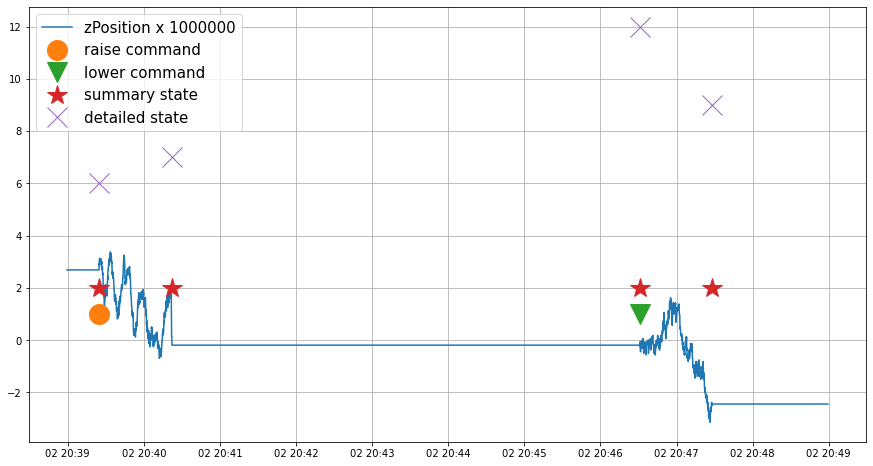

In [66]:
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(dfz.zPosition*1e6, label='zPosition x 1000000')
plt.plot(dfr.raiseM1M3, 'o', label='raise command', markersize=20)
plt.plot(dfl.lowerM1M3, 'v', label='lower command', markersize=20)
plt.plot(dfe.summaryState, '*', label='summary state', markersize=20)
plt.plot(dfd.detailedState, 'x', label='detailed state', markersize=20)
plt.legend(fontsize=15)
plt.grid();

In [4]:
for i in range(1,13):
    print(i, MTM1M3.DetailedState(i))

1 DetailedState.DISABLED
2 DetailedState.FAULT
3 DetailedState.OFFLINE
4 DetailedState.STANDBY
5 DetailedState.PARKED
6 DetailedState.RAISING
7 DetailedState.ACTIVE
8 DetailedState.LOWERING
9 DetailedState.PARKEDENGINEERING
10 DetailedState.RAISINGENGINEERING
11 DetailedState.ACTIVEENGINEERING
12 DetailedState.LOWERINGENGINEERING


### check the forces

In [67]:
#what is the best way to check the status of the FB??? --------

m1m3ForceBalance = await m1m3.evt_appliedBalanceForces.aget(timeout=10.)
print("starting with magnitude of the m1m3 balance force ---", m1m3ForceBalance.forceMagnitude, "----",
      pd.to_datetime(m1m3ForceBalance.private_sndStamp, unit='s'))

starting with magnitude of the m1m3 balance force --- 0.0 ---- 2021-03-02 20:38:40.947132672


In [71]:
m1m3ForceBalance = await m1m3.evt_appliedBalanceForces.aget(timeout=10.)
if not m1m3ForceBalance.forceMagnitude:
    await m1m3.cmd_enableHardpointCorrections.set_start(timeout=10)
    await asyncio.sleep(3.)
    m1m3ForceBalance = await m1m3.evt_appliedBalanceForces.aget(timeout=10.)
    print("Magnitude of the m1m3 force balance system", m1m3ForceBalance.forceMagnitude)

Magnitude of the m1m3 force balance system 13.004631996154785


In [72]:
fx = [0]*12
fy = [0]*100
fz = [0]*156
await m1m3.cmd_applyOffsetForces.set_start(xForces=fx, yForces=fy, zForces=fz) #not valid in ActiveState
await m1m3.cmd_applyAberrationForces.set_start(zForces=fz) #not valid in ActiveState
await m1m3.cmd_applyActiveOpticForces.set_start(zForces=fz)

In [73]:
fel = await m1m3.evt_appliedElevationForces.aget(timeout=10.)
faz = await m1m3.evt_appliedAzimuthForces.aget(timeout=10.)
fth = await m1m3.evt_appliedThermalForces.aget(timeout=10.)
fba = await m1m3.evt_appliedBalanceForces.aget(timeout=10.)
fac = await m1m3.evt_appliedAccelerationForces.aget(timeout=10.)
fve = await m1m3.evt_appliedVelocityForces.aget(timeout=10.)
fst = await m1m3.evt_appliedStaticForces.aget(timeout=10.)
fab = await m1m3.evt_appliedAberrationForces.aget(timeout=10.)
fof = await m1m3.evt_appliedOffsetForces.aget(timeout=10.)
fao = await m1m3.evt_appliedActiveOpticForces.aget(timeout=10.)

In [74]:
ftel = await m1m3.tel_forceActuatorData.aget(timeout=10.)

appliedElevationForces DDS read queue is filling: 10 of 100 elements
appliedCylinderForces DDS read queue is filling: 12 of 100 elements
appliedBalanceForces DDS read queue is filling: 13 of 100 elements
appliedAzimuthForces DDS read queue is filling: 12 of 100 elements
appliedActiveOpticForces DDS read queue is filling: 12 of 100 elements
appliedAberrationForces DDS read queue is filling: 12 of 100 elements
powerSupplyData DDS read queue is filling: 11 of 100 elements
pidData DDS read queue is filling: 11 of 100 elements
inclinometerData DDS read queue is filling: 11 of 100 elements
imsData DDS read queue is filling: 12 of 100 elements
hardpointMonitorData DDS read queue is filling: 12 of 100 elements
hardpointActuatorData DDS read queue is filling: 12 of 100 elements
gyroData DDS read queue is filling: 12 of 100 elements
forceActuatorData DDS read queue is filling: 12 of 100 elements
accelerometerData DDS read queue is filling: 11 of 100 elements
preclippedForces DDS read queue is fi

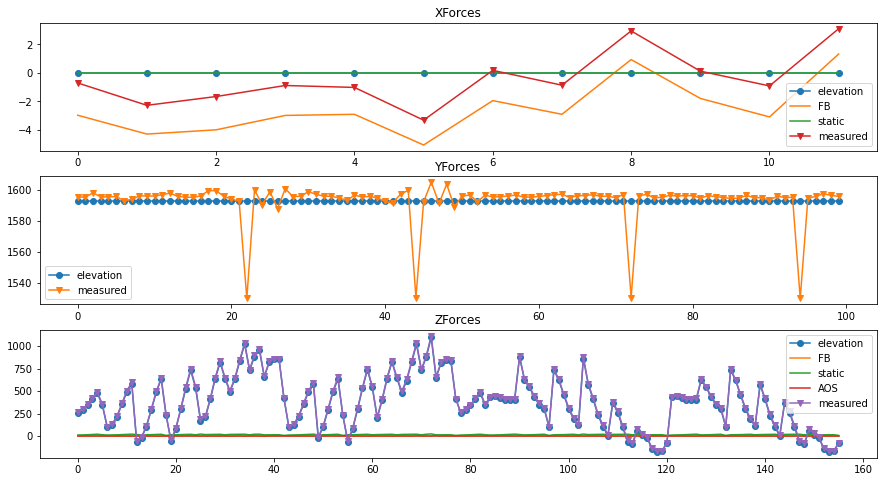

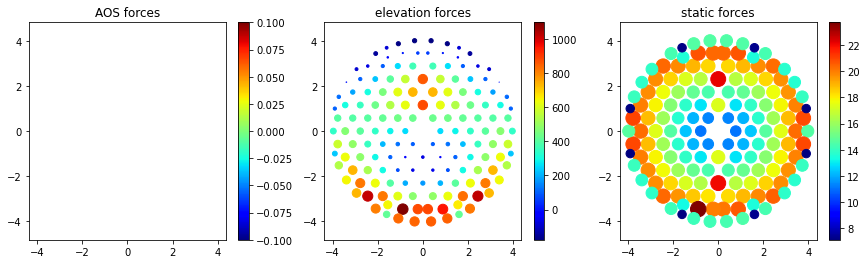

In [98]:
def plotForces(fel, fba, fst, fao):
    fig, ax = plt.subplots(3,1, figsize=(15,8))
    ax[0].plot(fel.xForces, '-o', label='elevation');
    ax[0].plot(fba.xForces, label='FB')
    ax[0].plot(fst.xForces, label='static')
    ax[0].plot(ftel.xForce, '-v', label='measured')
    ax[0].legend()
    ax[0].set_title('XForces')
    ax[1].plot(fel.yForces, '-o', label='elevation');
    #ax[1].plot(fba.yForces, label='FB')
    #ax[1].plot(fst.yForces, label='static')
    ax[1].plot(ftel.yForce, '-v', label='measured')
    ax[1].legend()
    ax[1].set_title('YForces')
    ax[2].plot(fel.zForces, '-o', label='elevation');
    ax[2].plot(fba.zForces, label='FB')
    ax[2].plot(fst.zForces, label='static')
    ax[2].plot(fao.zForces, label='AOS')
    ax[2].plot(ftel.zForce, '-v', label='measured')
    ax[2].set_title('ZForces')
    ax[2].legend()
    
    fig2, ax=plt.subplots( 1,3, figsize = [15,4])
    aa = np.array(fao.zForces)
    img = ax[0].scatter(xact, yact, c=aa, s=abs(aa)*2)
    #plt.jet()
    ax[0].axis('equal')
    ax[0].set_title('AOS forces')
    fig.colorbar(img, ax=ax[0])

    aa = np.array(fel.zForces)
    img = ax[1].scatter(xact, yact, c=aa, s=abs(aa)*0.1)
    #plt.jet()
    ax[1].axis('equal')
    ax[1].set_title('elevation forces')
    fig.colorbar(img, ax=ax[1])
    
    aa = np.array(fst.zForces)
    img = ax[2].scatter(xact, yact, c=aa, s=abs(aa)*10)
    #plt.jet()
    ax[2].axis('equal')
    ax[2].set_title('static forces')
    fig.colorbar(img, ax=ax[2])
plotForces(fel, fba, fst, fao)

In [110]:
aa = np.array(ftel.yForce)
bb = np.array(fel.yForces)
idx = aa<bb
for i in range(100):
    if idx[i]:
        print(i,aa[i], bb[i], aa[i]-bb[i])

21 1592.7860107421875 1592.81982421875 -0.0338134765625
22 1529.747314453125 1592.81982421875 -63.072509765625
24 1590.6021728515625 1592.81982421875 -2.2176513671875
26 1588.0687255859375 1592.81982421875 -4.7510986328125
40 1592.6651611328125 1592.81982421875 -0.1546630859375
41 1591.5706787109375 1592.81982421875 -1.2491455078125
44 1530.2391357421875 1592.81982421875 -62.5806884765625
45 1592.465087890625 1592.81982421875 -0.354736328125
47 1591.3685302734375 1592.81982421875 -1.4512939453125
49 1589.1341552734375 1592.81982421875 -3.6856689453125
52 1592.5784912109375 1592.81982421875 -0.2413330078125
72 1530.326171875 1592.81982421875 -62.49365234375
94 1529.8624267578125 1592.81982421875 -62.9573974609375


In [76]:
max(abs(np.array(fof.zForces)))

0.0

In [77]:
fx = [2]*12
fy = [3]*100
fz = [-5]*156
await m1m3.cmd_applyOffsetForces.set_start(xForces=fx, yForces=fy, zForces=fz)
#await m1m3.cmd_applyAberrationForces.set_start(xForces=fx, yForces=fy, zForces=fz)
#await m1m3.cmd_applyActiveOpticForces.set_start(xForces=fx, yForces=fy, zForces=fz)

appliedAberrationForces DDS read queue is filling: 10 of 100 elements


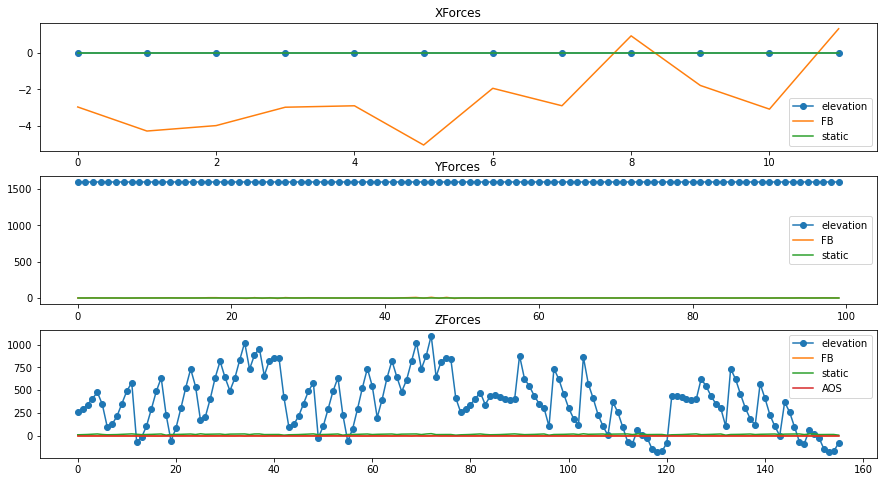

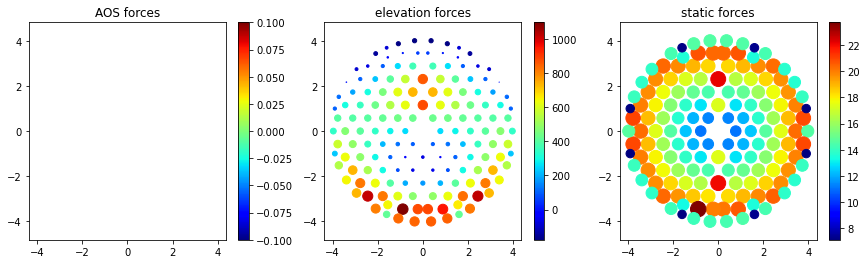

In [78]:
fel = await m1m3.evt_appliedElevationForces.aget(timeout=10.)
faz = await m1m3.evt_appliedAzimuthForces.aget(timeout=10.)
fth = await m1m3.evt_appliedThermalForces.aget(timeout=10.)
fba = await m1m3.evt_appliedBalanceForces.aget(timeout=10.)
fac = await m1m3.evt_appliedAccelerationForces.aget(timeout=10.)
fve = await m1m3.evt_appliedVelocityForces.aget(timeout=10.)
fst = await m1m3.evt_appliedStaticForces.aget(timeout=10.)
fab = await m1m3.evt_appliedAberrationForces.aget(timeout=10.)
fof = await m1m3.evt_appliedOffsetForces.aget(timeout=10.)
fao = await m1m3.evt_appliedActiveOpticForces.aget(timeout=10.)
ftel = await m1m3.tel_forceActuatorData.aget(timeout=10.)
plotForces(fel, fba, fst, fao)

In [79]:
max(abs(np.array(fof.zForces)))

5.0

### Check the forces add up as expected

In [80]:
xyz = 'xyz'
nForce = [12, 100, 156]
for i in range(3):
    print('%s diff'%xyz[i], end=" ")
    for j in range(nForce[i]):
        diff = \
        getattr(fel, '%sForces'%(xyz[i]))[j] + getattr(faz, '%sForces'%(xyz[i]))[j] + getattr(fth, '%sForces'%(xyz[i]))[j] + \
        getattr(fba, '%sForces'%(xyz[i]))[j] + getattr(fac, '%sForces'%(xyz[i]))[j] + getattr(fve, '%sForces'%(xyz[i]))[j] + \
        getattr(fst, '%sForces'%(xyz[i]))[j] + getattr(fof, '%sForces'%(xyz[i]))[j]  \
            - getattr(ftel, '%sForce'%(xyz[i]))[j] 
        if i==2: #only for z forces
            diff = diff + getattr(fao, '%sForces'%(xyz[i]))[j] + getattr(fab, '%sForces'%(xyz[i]))[j] 
        print('%d, %.1f'%(j,diff), end=" | ")
        if abs(diff)>1:
            print('\nfel faz fth fba fac, fve fst fof ftel, (fao fab) ')
            print('%d -------------------------------------------------'%j)
            print('%.1f, %.1f, %.1f, %.1f, %.1f, %.1f, %.1f, %.1f, %.1f, '%(
                getattr(fel, '%sForces'%(xyz[i]))[j], getattr(faz, '%sForces'%(xyz[i]))[j], getattr(fth, '%sForces'%(xyz[i]))[j],
                getattr(fba, '%sForces'%(xyz[i]))[j], getattr(fac, '%sForces'%(xyz[i]))[j], getattr(fve, '%sForces'%(xyz[i]))[j],
                getattr(fst, '%sForces'%(xyz[i]))[j], getattr(fof, '%sForces'%(xyz[i]))[j],
                getattr(ftel, '%sForce'%(xyz[i]))[j] ), end="")
            if i==2:
                print('%.1f, %.1f,'%(getattr(fao, '%sForces'%(xyz[i]))[j], getattr(fab, '%sForces'%(xyz[i]))[j]))
            break
    print('\n')

x diff 0, -0.3 | 1, -0.0 | 2, -0.3 | 3, -0.1 | 4, 0.1 | 5, 0.3 | 6, -0.1 | 7, -0.0 | 8, -0.0 | 9, 0.1 | 10, -0.2 | 11, 0.2 | 

y diff 0, -0.1 | 1, -0.2 | 2, -0.2 | 3, -0.1 | 4, 0.1 | 5, -0.1 | 6, 0.3 | 7, -0.0 | 8, -0.2 | 9, -0.2 | 10, 0.1 | 11, -0.3 | 12, -0.1 | 13, 0.3 | 14, 0.1 | 15, 0.2 | 16, 0.3 | 17, -0.2 | 18, -0.1 | 19, -0.2 | 20, -0.0 | 21, 0.1 | 22, 59.5 | 
fel faz fth fba fac, fve fst fof ftel, (fao fab) 
22 -------------------------------------------------
1592.8, 0.0, 0.0, -6.6, 0.0, 0.0, 0.0, 3.0, 1529.7, 

z diff 0, 0.1 | 1, 0.1 | 2, -0.5 | 3, -0.3 | 4, -0.4 | 5, 0.1 | 6, -0.1 | 7, 0.4 | 8, -0.1 | 9, 0.5 | 10, 0.2 | 11, -0.1 | 12, -0.5 | 13, -0.1 | 14, 0.2 | 15, -0.7 | 16, -0.2 | 17, 0.2 | 18, -0.1 | 19, -0.1 | 20, 0.2 | 21, 0.6 | 22, 0.0 | 23, 0.2 | 24, 0.5 | 25, -0.5 | 26, 0.4 | 27, 0.1 | 28, 0.6 | 29, 0.2 | 30, -0.4 | 31, -0.1 | 32, -0.2 | 33, -0.2 | 34, -0.1 | 35, 0.0 | 36, -0.0 | 37, -0.2 | 38, 0.4 | 39, -0.1 | 40, -0.3 | 41, -0.3 | 42, -0.4 | 43, 0.3 | 44, 0.6 | 45

In [87]:
## demonstrate the problem with EFD data
end = Time(datetime.now()) #- timedelta(minutes=75)
#end = Time('2021-02-04T22:50:00')
#end = Time('2021-02-12T22:24:00')
start = end - timedelta(seconds=2)
dftel = await client.select_time_series('lsst.sal.MTM1M3.forceActuatorData', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
dfel = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedElevationForces', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
dfba = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedBalanceForces', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
dfst = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedStaticForces', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)

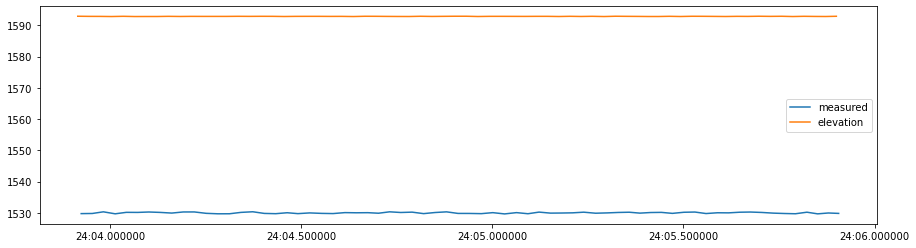

In [93]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
plt.plot(dftel.yForce22, label='measured')
plt.plot(dfel.yForces22, label='elevation')
plt.legend()

In [86]:
len(dftel)

4095

### check the force components against expectations

In [ ]:
m1m3Angle = await m1m3.tel_inclinometerData.aget()
eA = m1m3Angle.inclinometerAngle
print("m1m3 elevation Angle", eA)

In [ ]:
lutFile = '%s/notebooks/ts_m1m3support/SettingFiles/Tables/ElevationZTable.csv'%os.environ['HOME']
lutel = pd.read_csv(lutFile)

In [ ]:
def lookUpElevation(lute, zA):
    eForces = np.zeros(156)
    for i in range(156):
        coeff = [lute['Coefficient %d'%j][i] for j in range(5,-1,-1)]
        mypoly = np.poly1d(coeff)
        eForces[i] = mypoly(zA)
    return eForces
eForces = lookUpElevation(lutel, 90-eA)

In [ ]:
plt.plot(eForces, label = 'expected')
plt.plot([fel.zForces[i] for i in range(156)], '--', label='EFD')
plt.legend()
plt.title('Elevation Z Forces');

In [ ]:
lutFile = '%s/notebooks/ts_m1m3support/SettingFiles/Tables/StaticZTable.csv'%os.environ['HOME']
lutst = pd.read_csv(lutFile)

In [ ]:
plt.plot(lutst['ZForce'], label = 'expected')
plt.plot([fst.zForces[i] for i in range(156)], label='EFD')
plt.legend()
plt.title('Static Z Forces');

### Do a slew, then check the LUT again
We can either do this by commanding the mount using the ptg, or we can create a Controller object to send mount telemetry.

In [ ]:
#use this if we are commanding the mount using the ptg
await ptgSlew(ptg, 80., 0., 0.)

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
print('Are we tracking?', mountStatus.elevation , mountStatus.azimuth , rotStatus.inPosition)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)

#### If we are to use the Controller object, we need to take the mount out of the disabled/enabled states so that it stops sending telemetry data.

In [ ]:
await salobj.set_summary_state(mount, salobj.State.STANDBY)

In [ ]:
mount = salobj.Controller(name="MTMount")
await mount.start_task

# Do this for every desired elevation angle.
mount.evt_target.set_put(elevation=45)

await mount.close()
await rotator.close()

### check angle and LUT after the slew

In [ ]:
mountAngle = await mount.tel_elevation.aget(timeout=10.)
print("mount elevation angle", mountAngle.angleActual)
elev = mountAngle.angleActual

In [ ]:
m1m3Angle = await m1m3.tel_inclinometerData.aget()
eA = m1m3Angle.inclinometerAngle
print("m1m3 elevation Angle", eA)

eForces = lookUpElevation(lutel, 90-eA)

In [ ]:
fel = await m1m3.evt_appliedElevationForces.aget(timeout=10.)
faz = await m1m3.evt_appliedAzimuthForces.aget(timeout=10.)
fth = await m1m3.evt_appliedThermalForces.aget(timeout=10.)
fba = await m1m3.evt_appliedBalanceForces.aget(timeout=10.)
fac = await m1m3.evt_appliedAccelerationForces.aget(timeout=10.)
fve = await m1m3.evt_appliedVelocityForces.aget(timeout=10.)
fst = await m1m3.evt_appliedStaticForces.aget(timeout=10.)
fab = await m1m3.evt_appliedAberrationForces.aget(timeout=10.)
fof = await m1m3.evt_appliedOffsetForces.aget(timeout=10.)
fao = await m1m3.evt_appliedActiveOpticForces.aget(timeout=10.)
ftel = await m1m3.tel_forceActuatorData.aget(timeout=10.)
plotForces(fel, fba, fst, fao)

In [ ]:
plt.plot(eForces, label = 'expected')
plt.plot([fel.zForces[i] for i in range(156)], '--', label='EFD')
plt.legend()
plt.title('Elevation Z Forces');

In [ ]:
plt.plot(lutst['ZForce'], label = 'expected')
plt.plot([fst.zForces[i] for i in range(156)], label='EFD')
plt.legend()
plt.title('Static Z Forces');

### Close up

In [ ]:
#if we started with enabled state, we need to put it back
await salobj.set_summary_state(m1m3, salobj.State.ENABLED) #enable m1m3

In [ ]:
await salobj.set_summary_state(mount, salobj.State.ENABLED)

### Check if the telescope is in tracking mode. If yes, need to stop stacking. 
The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)